In [1]:
from rubin_scheduler.scheduler.model_observatory import ModelObservatory
from rubin_scheduler.scheduler.surveys import BaseSurvey, ScriptedSurvey
from rubin_scheduler.scheduler.utils import empty_observation, scheduled_observation
from rubin_scheduler.scheduler.schedulers import CoreScheduler, SimpleFilterSched
from rubin_scheduler.scheduler import sim_runner

import numpy as np
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline

import pandas as pd

In [14]:
# load up a model observatory.
nside=32  # Specify the HEALpix resolution we want to do everything in.
mjd_start = 60218
mo = ModelObservatory(nside=nside, mjd_start=mjd_start, downtimes="ideal")

In [15]:
conditions = mo.return_conditions()

In [16]:
# Let's look at how scheduled observations work
help(scheduled_observation)

Help on function scheduled_observation in module rubin_scheduler.scheduler.utils.utils:

scheduled_observation(n=1)
    Make an array to hold pre-scheduling observations
    
    Returns
    -------
    result : np.array
    
    
    Note
    ----
    mjd_tol : `float`
        The tolerance on how early an observation can execute (days).
        Observation will be considered valid to attempt
        when mjd-mjd_tol < current MJD < flush_by_mjd (and other
        conditions below pass)
    dist_tol : `float`
        The angular distance an observation can be away from the
        specified RA,Dec and still count as completing the observation
        (radians).
    alt_min : `float`
        The minimum altitude to consider executing the observation
        (radians).
    alt_max : `float`
        The maximuim altitude to try observing (radians).
    HA_max : `float`
        Hour angle limit. Constraint is such that for hour angle
        running from 0 to 24 hours, the target RA,Dec m

In [17]:
# Let's make a few scheduled observations manually, then load them into a scripted survey object

# Array of 10 observations to schedule
obs = scheduled_observation(10)
# Set these to point exactly at the south pole
obs['RA'] = 0
obs['dec'] = np.radians(-90.)
# Set them to be every 30 minutes, starting 2 hours from current mjd
obs['mjd'] = conditions.mjd + np.arange(10)*0.5/24 + 2./24.
obs['exptime'] = 30
obs['nexp'] = 2
obs['filter'] = 'i'
obs['scheduler_note'] = 'scripted'
obs['flush_by_mjd'] = conditions.mjd + 10

# This is a little tichy. Need to set these, 
# Otherwise they will not pass if-statements
# How early an observation can be attempted
obs['mjd_tol'] = 10./3600/24.  # Seconds to days
# distance away from the desired RA,Dec to consider an observation as counting
obs['dist_tol'] = np.radians(3.) 
obs['alt_min'] = 0
obs['alt_max'] = np.radians(85.)
# This is effectively no hour angle limit. XXX--need to document better
obs['HA_max'] = 0. # Hours
obs['HA_min'] = 24.

# You can make this array of scheduled observations any way you like! Can be one observations, or lots over years.

In [18]:
print('Our 10 scheduled observations')
print(pd.DataFrame(obs))

Our 10 scheduled observations
   ID   RA       dec           mjd  flush_by_mjd  exptime filter  rotSkyPos  \
0   0  0.0 -1.570796  60218.083333       60228.0     30.0      i        0.0   
1   0  0.0 -1.570796  60218.104167       60228.0     30.0      i        0.0   
2   0  0.0 -1.570796  60218.125000       60228.0     30.0      i        0.0   
3   0  0.0 -1.570796  60218.145833       60228.0     30.0      i        0.0   
4   0  0.0 -1.570796  60218.166667       60228.0     30.0      i        0.0   
5   0  0.0 -1.570796  60218.187500       60228.0     30.0      i        0.0   
6   0  0.0 -1.570796  60218.208333       60228.0     30.0      i        0.0   
7   0  0.0 -1.570796  60218.229167       60228.0     30.0      i        0.0   
8   0  0.0 -1.570796  60218.250000       60228.0     30.0      i        0.0   
9   0  0.0 -1.570796  60218.270833       60228.0     30.0      i        0.0   

   rotTelPos  rotTelPos_backup  ...   mjd_tol  dist_tol alt_min  alt_max  \
0        0.0            

In [19]:
# Instantiate a scripted survey object
ss = ScriptedSurvey([])
# Load our scheduled observations into it
ss.set_script(obs)

In [20]:
# Our friend the SCP survey from previous notebook
class ScpSurvey(BaseSurvey):
    """A South Celestial Pole survey"""
    def generate_observations_rough(self, conditions):
        obs = empty_observation()
        obs['RA'] = 0.
        obs['dec'] = np.radians(-87.)
        obs['exptime'] = 30.
        obs['nexp'] = 2
        obs['filter'] = 'r'
        # If it's been 12 hours or more, don't try to execute the observation anymore
        obs['flush_by_mjd'] = conditions.mjd + 0.5
        obs['note'] = 'scp'  # Always good to set the note to which survey generated the observation
        result = [obs] * 3
        return result

In [21]:
scp = ScpSurvey([])

In [22]:
# Now, we can run both surveys at the same time. 
# We're sending these as a list-of-lists. If nothing in the first list can provide an observation, the
# scheduler moves onto the next list. This structure helps with computational efficiency--we only compute 
# the scp reward function when we might actually need it. The list-of-list of survey objects
# functions as a decision-tree. If nothing in the first list can provide observation(s), it moves on to 
# the surveys in the next list.
scheduler = CoreScheduler([[ss], [scp]], nside=nside)

# It's up to the user to make sure you have a robust and flexible survey object at the end of your list-of-lists that 
# can execute at any time under any conditions.


In [23]:
# Run for a day
mo, scheduler, observations = sim_runner(mo, scheduler, survey_length=1.0,
                                         verbose=True)

progress = 98.37%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 895 observations
ran in 0 min = 0.0 hours


In [24]:
# Wow, note now we have 895 observations. Down from 959 before. That's what 10 filter changes in a night will do.
np.unique(observations['scheduler_note'])

array(['', 'scripted'], dtype='<U40')

Text(0, 0.5, 'Altitude (degrees)')

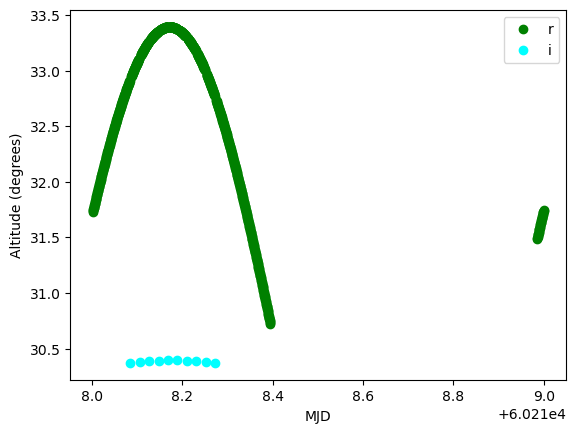

In [25]:
# let's plot and color-code by filter
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}

for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['mjd'][in_filt], np.degrees(observations['alt'][in_filt]), 'o',
                 color=f2c[filtername], label=filtername)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Altitude (degrees)')


Keep in mind, that `mjd_tol` is a tricky parameter. If you make it very large, your observation might execute earlier than you like. Set it small, and your background survey might take too much time and block it out. Here, our simple SCP survey only generates 3 observations at a time, but other survey objects (like DDFs and contiguous blobs) tend to be longer.

Note on `Survey` objects. 1-10s of survey objects are fine. The baseline simulation currently uses 17 survey objects. But the code is *not* designed to scale up to thousands of survey objects. If you are tempted to generate a decision-tree with thousands of survey objects, there's probably a better way to do it.

In [26]:
# Let's run it again but stop 0.1 days in:
scp = ScpSurvey([])
ss = ScriptedSurvey([])
# Need to reset the obs so it doesn't think they have been observed
obs['observed'] = False
ss.set_script(obs)
scheduler = CoreScheduler([[ss], [scp]], nside=nside)
mo = mo = ModelObservatory(nside=nside, mjd_start=mjd_start, downtimes="ideal")

mo, scheduler, observations = sim_runner(mo, scheduler,survey_length=0.1,
                                                 verbose=True)

progress = 83.53%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 225 observations
ran in 0 min = 0.0 hours


In [27]:
# When the conditions object goes into the scheduler object, the CoreScheduler checks ALL the
# survey objects to see if they have any scheduled observations and adds their MJDs to the 
# conditions.scheduled_observations attribute. This make it easier for low tier survey 
# objects to check how much time they have to
# work with and respect the time-slots of upcoming scheduled observations. This is currently the
# only communication that goes on between survey objects.
conditions = mo.return_conditions()
scheduler.update_conditions(conditions)
scheduler.conditions.scheduled_observations

array([60218.10416667, 60218.125     , 60218.14583333, 60218.16666667,
       60218.1875    , 60218.20833333, 60218.22916667, 60218.25      ,
       60218.27083333])